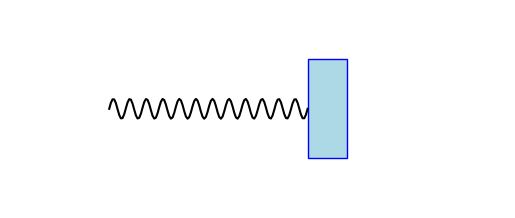

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def draw_spring(ax, start, end, num_coils=10, width=0.1, **kwargs):
    """
    Draw a spring from start to end with given number of coils and width.
    """
    # Linear interpolation of points along the spring length
    t = np.linspace(0, 1, num_coils * 10)
    x = np.linspace(start[0], end[0], num_coils * 10)
    y = np.sin(2 * np.pi * t * num_coils) * width

    # Plot the spring
    ax.plot(x, y + (start[1] + end[1]) / 2, **kwargs)

    # Plot lines to connect the spring to the start and end points
    ax.plot([start[0], x[0]], [start[1], y[0] + (start[1] + end[1]) / 2], **kwargs)
    ax.plot([x[-1], end[0]], [y[-1] + (start[1] + end[1]) / 2, end[1]], **kwargs)

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')

# Spring start and end points
start_point = (0, 0)
end_point = (1, 0)

# Draw the spring
draw_spring(ax, start_point, end_point, num_coils=12, width=0.05, color='black')

# Draw the box at the end of the spring
box = plt.Rectangle((end_point[0], -0.25), 0.2, 0.5, linewidth=1, edgecolor='blue', facecolor='lightblue')
ax.add_patch(box)

plt.xlim(-0.5, 2)
plt.ylim(-0.5, 0.5)
plt.show()


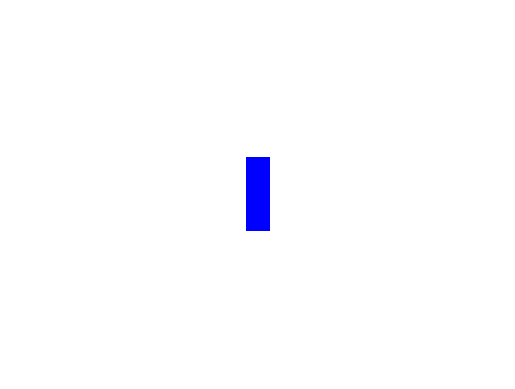

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

# Constants for the simulation
k = 0.1  # Spring constant
mass = 1.0  # Mass of the box
omega = np.sqrt(k / mass)  # Angular frequency (sqrt(k/m))
amplitude = 1.0  # Amplitude of oscillation

# Time array
time = np.linspace(0, 10, 300)

# Function to calculate position of the box at time t
def position(t):
    return amplitude * np.cos(omega * t)

fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)

# Plot a line for the spring, initialized to the rest position
spring, = ax.plot([], [], 'r-', linewidth=2)

# Create a rectangle for the box
box = Rectangle((-0.1, -0.2), 0.2, 0.4, fc='blue')
ax.add_patch(box)

def init():
    """Initialize the background of the animation."""
    spring.set_data([], [])
    return spring, box

def animate(t):
    """Update the animation by a single frame."""
    x = position(t)
    
    # Update the spring's end position
    spring.set_data([0, x], [0, 0])
    
    # Update the box's position
    box.set_x(x - 0.1)
    
    return spring, box

# Create the animation
ani = FuncAnimation(fig, animate, frames=time, init_func=init, blit=True, interval=20)

plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()

ani.save("test.mp4", writer = 'ffmpeg', fps = 60)


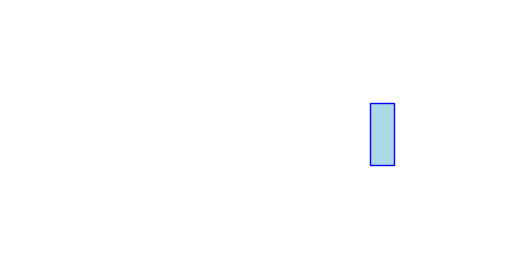

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

# Define the draw_spring function for drawing a dynamic spring
def draw_spring(ax, start, end, num_coils=10, width=0.1, **kwargs):
    t = np.linspace(0, 1, num_coils * 10)
    x = np.linspace(start[0], end[0], num_coils * 10)
    y = np.sin(2 * np.pi * t * num_coils) * width
    ax.plot(x, y + (start[1] + end[1]) / 2, **kwargs)
    ax.plot([start[0], x[0]], [start[1], y[0] + (start[1] + end[1]) / 2], **kwargs)
    ax.plot([x[-1], end[0]], [y[-1] + (start[1] + end[1]) / 2, end[1]], **kwargs)

# Initialize the plot
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')
ax.set_xlim(-2, 2)
ax.set_ylim(-1, 1)

# Initialize the spring end point and box
spring_end = [1, 0]
box = Rectangle((spring_end[0]-0.1, -0.25), 0.2, 0.5, linewidth=1, edgecolor='blue', facecolor='lightblue')
ax.add_patch(box)

# Animation update function
def update(frame):
    ax.clear()
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-1, 1)
    
    # Update the spring's end position based on simple harmonic motion
    spring_end[0] = 1 + np.sin(frame)
    
    # Redraw the spring and box with updated positions
    draw_spring(ax, [0, 0], spring_end, num_coils=12, width=0.05, color='black')
    box.set_x(spring_end[0]-0.1)
    ax.add_patch(Rectangle((spring_end[0]-0.1, -0.25), 0.2, 0.5, linewidth=1, edgecolor='blue', facecolor='lightblue'))
    
    return ax,

# Create the animation
ani = FuncAnimation(fig, update, frames=np.linspace(0, 6*np.pi, 100), blit=False, interval=50)

plt.show()
ani.save("test.mp4", writer = 'ffmpeg', fps = 60)
